# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from itertools import product as it_product

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

# Parameters

In [3]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [4]:
all_data_path = r'../../data/snow_data_clean.pkl'

In [5]:
long_series_df = pd.read_pickle(all_data_path).fillna(0)  # TODO: fix fillna func in data cleaning notebook

def resample_by_month(df, time_col):
    """resample df on monthly basis using specified timestamp column"""
    
    # handling of time_col
    acceptable_time_col = ['timestamp', 'pseudo_ts']
    other_time_col = [x for x in acceptable_time_col if x != time_col].pop()
    if time_col not in acceptable_time_col:
        raise Exception(f'must be in {acceptable_time_col}')
    
    month = (df
             .set_index(f'{time_col}')
             .resample('M')
             .agg({'base': 'mean', 'snowfall': 'sum', 'station': 'first', 
                   'region': 'first', 'state': 'first', 'ski_yr': 'first',
                   f'{other_time_col}': 'first'})
            )
    return month

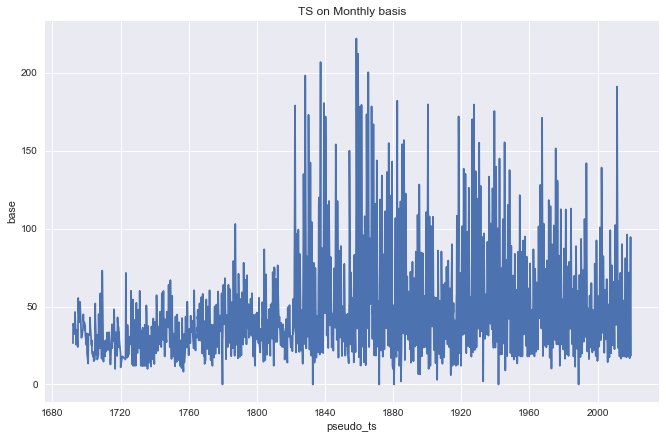

In [6]:
month_ts_df = resample_by_month(long_series_df, 'timestamp')
g = sns.lineplot(data=month_ts_df.reset_index(), x='pseudo_ts', y='base')
g.set_title("TS on Monthly basis");

In [7]:
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .reset_index()
              .query('region=="Colorado"')
              [['base', 'pseudo_ts', 'station']]
              .sort_values(by='pseudo_ts')
             )
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [8]:
def AC_PAC_plotter(df=None, lags=30, differences=None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    smg.tsaplots.plot_acf(x=df.base,
                          lags=lags, alpha=0.05,
                          use_vlines=True, unbiased=False,
                          missing='conservative',
                          title=f'Autocorrelation: Differencing: {differences}',
                          zero=True, ax=ax1
                          )
    smg.tsaplots.plot_pacf(x=df.base, lags=lags,
                           alpha=0.05, method='ldb', use_vlines=True,
                           title='Partial Autocorrelation', zero=True,
                           vlines_kwargs=None, ax=ax2)
    fig

In [9]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())

In [10]:
def y_and_yhat_plotter(model=None, endog=None, exog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict(df.values, exog)
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

In [47]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for statsmodels ARIMA models """
    def __init__(self, model_class, order, seasonal_order=None):
        self.model_class = model_class
        self.order=order
        self.seasonal_order=seasonal_order
    def fit(self, endog=None, exog=None):
        self.endog = endog
        self.exog=exog
        self.sm_model_ = self.model_class(endog=self.endog, exog=self.exog, 
                                       order=self.order, 
                                       seasonal_order=self.seasonal_order)
        self.results_ = self.sm_model_.fit()
        self.mse, self.mae = self.results_.mse, self.results_.mae
        self.bic, self.aic = self.results_.bic, self.results_.aic
        #return self.results_
    def predict(self, X):
        X = (X
             .reindex(['timestamp', 'base', 'snowfall'], axis=1)
             .set_index('timestamp'))
        return self.results_.predict(start=X.iloc[0].name, 
                                     end=X.iloc[-1].name, 
                                     exog=X.iloc[:, 2])
    def summary(self):
        return self.results_.summary()

In [43]:
def time_crossval(model, X, y):
    """takes sklearn-API model and returns CV results
    input:
        model: sklearn-API model
        X: 
        Y:
    """
    time_split = TimeSeriesSplit(8)
    cv_results = cross_validate(model, X, y, cv=time_split, 
                            scoring=['neg_root_mean_squared_error', 'r2',
                                     'neg_mean_absolute_error'], n_jobs=1) 
    return cv_results

In [58]:
def pdq_maker(order_limit=2, s_order_limit=1, period=12):
    """generate all possible SARIMA orders for range"""
    p = d = q = range(0, order_limit)
    P = D = Q = range(0, s_order_limit)
    # Generate all different combinations of pdq/PDQ triplets
    pdq = list(it_product(p, d, q))
    seasonal_PDQ = [(x[0], x[1], x[2], period) for x in list(it_product(p, d, q))]
    return (pdq, seasonal_PDQ)

def IC_chooser(unwrapped_mod=None, X=None, y=None, order_limit=(2,1)):
    """Use AIC/BIC to choose best model from grid of (pdq)(PDQ)S models
    Params:
        model:  sklearn model
        X:  
        y:
        order_limit:  tuple of highest order to use for pdq/PDQ
    Returns:
        df of AIC/BIC statistics
    """
    pdq, seasonal_pdq = pdq_maker(*order_limit)
    AIC, BIC = {}, {}
    for order in pdq:
        for season_order in seasonal_pdq:
            model = SMWrapper(unwrapped_mod, order=order, seasonal_order=season_order)
            model.fit(endog=X)
            AIC[f"{order}{season_order}12"] = model.aic
            BIC[f"{order}{season_order}12"] = model.bic
    ic_df = (pd.DataFrame.from_dict(AIC, orient='index').rename(columns={0:"AIC"})
             .merge(right=
                   pd.DataFrame.from_dict(BIC, orient='index').rename(columns={0:"BIC"}),
                   left_index=True, right_index=True)
             .sort_values(by='BIC', ascending=True)
             )
    return ic_df

## ARIMA and extensions

<Figure size 792x504 with 0 Axes>

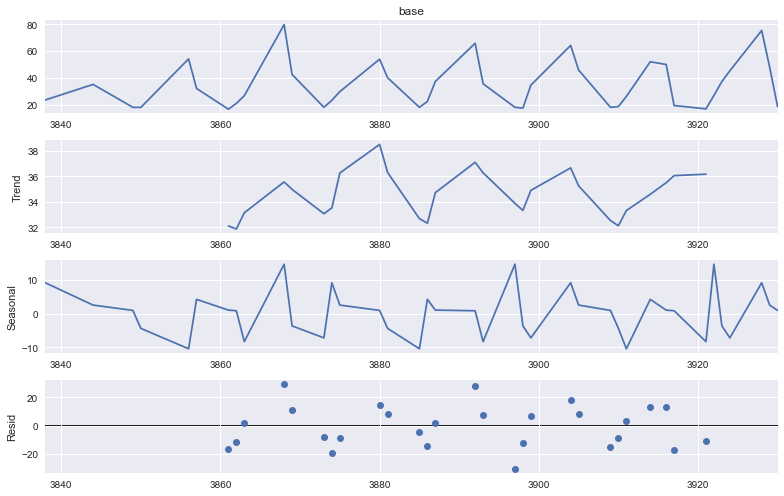

In [14]:
decomposition = smt.seasonal.seasonal_decompose(co_base_ts.query('station=="Arapahoe Basin"').base, period=12)  
fig = plt.figure()
fig = decomposition.plot();

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

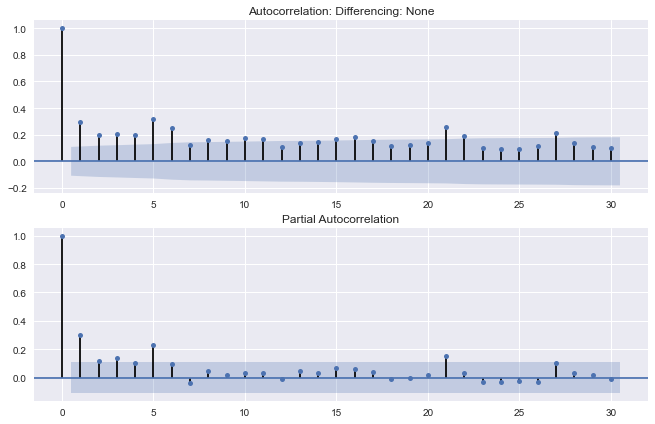

In [15]:
AC_PAC_plotter(co_base_ts)

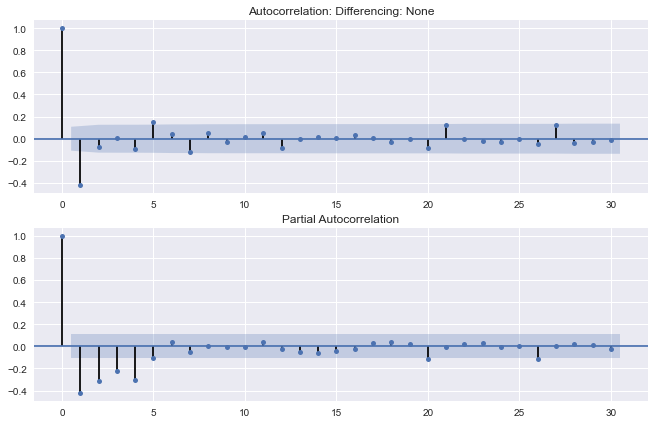

In [16]:
AC_PAC_plotter(co_base_ts.assign(base=lambda x:x.base.diff(periods=1)).fillna(0))

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.
I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [49]:
# try crossvalition on model 
# (p, d, q) | (AR, diff, MA) ; 
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        order=(0, 1, 1))

arima_model_fit = arima_model.fit(endog=month_ts_df.base)
time_crossval(model=arima_model, X=month_ts_df, 
              y=month_ts_df.shift(1).fillna(0))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

  FitFailedWarning)


{'fit_time': array([0.00292659, 0.00582528, 0.00487804, 0.00585556, 0.01171374,
        0.01073694, 0.00975871, 0.0127151 ]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_neg_root_mean_squared_error': array([nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_r2': array([nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan, nan, nan, nan])}

In [ ]:
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

In [ ]:
_ = arima_model_fit.plot_diagnostics(figsize=(15, 12))

In [71]:
IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=month_ts_df.base,  # too short but just testing
           y=month_ts_df.base.shift(1), order_limit=(2, 0))\
.applymap((lambda x : "{:,.0f}".format(x)))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,AIC,BIC
"(1, 0, 1)(1, 0, 1, 12)12","16,728","16,766"
"(1, 0, 1)(1, 1, 1, 12)12","16,748","16,779"
"(1, 0, 1)(0, 1, 1, 12)12","16,765","16,790"
"(1, 1, 1)(1, 0, 1, 12)12","16,849","16,881"
"(1, 0, 0)(1, 0, 1, 12)12","16,851","16,882"
...,...,...
"(0, 0, 0)(0, 1, 0, 12)12","19,049","19,056"
"(0, 1, 0)(0, 0, 0, 12)12","19,073","19,079"
"(0, 0, 1)(0, 0, 0, 12)12","19,066","19,084"
"(0, 0, 0)(0, 0, 1, 12)12","19,547","19,565"


there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

In [ ]:
start_d, end_d = '2004-08-01', '2006-07-30'
y_and_yhat_plotter(arima_model, co_base_ts[['base', 'pseudo_ts',]], 
                   #query_filter='pseudo_ts>@start_d & pseudo_ts<@end_d'
                  )

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [ ]:
IC_results = IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=month_ts_df.base,  # too short but just testing
                        y=month_ts_df.base.shift(1), order_limit=(2, 1))

In [68]:
IC_results.applymap(lambda x : "{:,.0f}".format(x))

,AIC,BIC
"(1, 0, 1)(1, 0, 1, 12)12","16,728","16,766"
"(1, 0, 1)(1, 1, 1, 12)12","16,748","16,779"
"(1, 0, 1)(0, 1, 1, 12)12","16,765","16,790"
"(1, 1, 1)(1, 0, 1, 12)12","16,849","16,881"
"(1, 0, 0)(1, 0, 1, 12)12","16,851","16,882"
...,...,...
"(0, 0, 0)(0, 1, 0, 12)12","19,049","19,056"
"(0, 1, 0)(0, 0, 0, 12)12","19,073","19,079"
"(0, 0, 1)(0, 0, 0, 12)12","19,066","19,084"
"(0, 0, 0)(0, 0, 1, 12)12","19,547","19,565"


In [72]:
sarima_model = smt.arima.model.ARIMA(endog=month_ts_df.base, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 12))
sarima_model_fit = sarima_model.fit()

In [73]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              base   No. Observations:                 3931
Model:             ARIMA(0, 1, 1)x(0, 1, [], 12)   Log Likelihood               -9073.617
Date:                           Thu, 04 Jun 2020   AIC                          18151.234
Time:                                   02:48:43   BIC                          18163.781
Sample:                               01-31-1692   HQIC                         18155.686
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0667      0.023      2.873      0.004       0.021       0.112
sigma2       216.6597      3.031     71.487      0.000     210.719     222.600
===================================================================================
Ljung-Box (Q):                     1098.46   Jarque-Bera (JB):             51535.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Regression with SARIMA Errors
Similar to ARIMAX but with more interpretable coefficients.
using snowfall data with powder -> packed powder and melt inference

In [74]:
reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=month_ts_df.base, exog=month_ts_df.snowfall,
                                              order=(0,1,1), seasonal_order=(0,1,0,12))
reg_w_sarima_results = reg_w_sarima.fit()
reg_w_sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                base   No. Observations:                 3931
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood               -9059.197
Date:                             Thu, 04 Jun 2020   AIC                          18124.395
Time:                                     02:48:44   BIC                          18143.215
Sample:                                 01-31-1692   HQIC                         18131.073
                                      - 07-31-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
snowfall       0.0146      0.003      4.966      0.000       0.009       0.020
ma.L1          0.0423      0.023      1.821      0.069      -0.003       0.088
sigma2       214.6406      2.964     72.409      0.000     208.831     220.450
===================================================================================
Ljung-Box (Q):                     1121.17   Jarque-Bera (JB):             53897.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.36   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
reg_w_sarima_results.predict(endog=month_ts_df.base, exog=month_ts_df.snowfall,)

pseudo_ts
1692-01-31     0.437215
1692-02-29    26.695061
1692-03-31    38.333465
1692-04-30    38.450854
1692-05-31    38.450854
                ...    
2019-03-31    66.281651
2019-04-30    94.088574
2019-05-31    71.762998
2019-06-30    44.659477
2019-07-31    20.728570
Freq: M, Length: 3931, dtype: float64

In [77]:
y_and_yhat_plotter(model=reg_w_sarima, endog=month_ts_df.base, exog=month_ts_df.snowfall,)

TypeError: Cannot convert input [[26.49090909 38.94545455 38.48       ... 75.41935484 48.05263158
 18.5       ]] of type <class 'numpy.ndarray'> to Timestamp

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb), 

### Panel Models
Linearmodels module?

# TF LSTM models
 

In [ ]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

# invert transform
inverted_X = scaler.inverse_transform(scaled_X)



In [ ]:
def fit_lstm(train, batch_size, n_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Prophet models
GAM timeseries model 